<a href="https://colab.research.google.com/github/SarahGhysels/SarahGhysels_thesis_2024/blob/Thesis/ThesisSarahGhysels_CNN_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Convolutional Neural Network

## Preparation

In [ ]:
#installing necessary files
%pip install split-folders tqdm
%pip install Augmentor
%pip uninstall scikit-learn -y
%pip install -U scikit-learn #need newest updat of sklearn for certain evaluation metrics

### Installing files and importing functions

In [ ]:
#Linking google drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
#Importing necessary functions
import os
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch import optim
from torchvision import datasets, models
from collections import OrderedDict
import Augmentor
import torch.nn as nn
import torchvision.transforms as transforms
from google.colab import files
import pandas as pd
import random
import shutil
from sklearn import metrics
import re
from torch.utils.data import Dataset, DataLoader, Subset
import cv2
import splitfolders
from torchvision.models import densenet161, DenseNet161_Weights, vgg16, VGG16_Weights, efficientnet_v2_s, EfficientNet_V2_S_Weights, resnet50, ResNet50_Weights
from torchvision import models

### Defining functions

#### Dataset and dataloader

In [ ]:
#Create PyTorch dataset
class imagedataset(Dataset):
    def __init__(self, y_values, dir_image,id_image, transform=None):
        # csv_file (string): Path to the csv file with annotations, root_dir (string): Directory with all the images
        self.DMY_dataframe = y_values
        self.dir_image = dir_image
        self.transform = transform
        self.id_image = id_image
        self.to_tensor = transforms.ToTensor()

    def __len__(self):
      return len(self.DMY_dataframe)

    def __getitem__(self, idx):
        image = cv2.imread(self.dir_image[idx])
        image = self.to_tensor(image)
        DMYield = self.DMY_dataframe[idx]
        id_image = self.id_image[idx]

        if self.transform:
            image = self.transform(image)

        return image, DMYield, id_image

In [ ]:
def data_loader(train_dataset, val_dataset, test_dataset, batch_size = 256, workers = 0, pin_memory = True): #test_dataset
#have set workers to 0 because efficientnet uses JAX which causes problems if combined with multiprocessing (num workers>0 = multiprocessing)
  train_loader = torch.utils.data.DataLoader(
      train_dataset,
      batch_size = batch_size,
      shuffle = True,
      num_workers = workers,
      pin_memory = pin_memory,
      sampler = None
  )

  val_loader = torch.utils.data.DataLoader(
      val_dataset,
      batch_size = batch_size,
      shuffle = False,
      num_workers = workers,
      pin_memory = pin_memory
  )

  test_loader = torch.utils.data.DataLoader(
      test_dataset,
      batch_size = batch_size,
      shuffle = False,
      num_workers = workers,
      pin_memory = pin_memory
  )

  return train_loader, val_loader, test_loader

#### Oversampling and data augmentation

In [ ]:
#Function to generate extra data by oversampling with Augmentor (creates new images by geometric transformations of existing ones)
def oversample_func(split_directory, folders, target_folders, requiredNbrOfImages):
    for i in range(len(folders)):
        path, dirs, files = next(os.walk(folders[i]))
        nbrOfImages = len(files)
        nbrOfImagesNeeded = requiredNbrOfImages - nbrOfImages

        if nbrOfImagesNeeded > 0:
            tfd = target_folders[i]
            print("saving in " + tfd)
            p = Augmentor.Pipeline(source_directory=folders[i], output_directory=tfd)
            p.flip_left_right(probability=0.5)
            p.rotate(probability=0.7, max_left_rotation=15, max_right_rotation=15)
            p.flip_left_right(probability=0.5)
            p.sample(nbrOfImagesNeeded, multi_threaded=False)


#### Model

##### Pre-trained models

In [ ]:
# #looking at models
# weights = models.DenseNet161_Weights.DEFAULT
# model = models.densenet161(weights=weights)
# print(dict(model.named_children()).keys())
# print(model.classifier)
# weights2 = models.VGG16_Weights.DEFAULT
# model2 = models.vgg16(weights=weights2)
# print(dict(model2.named_children()).keys())
# print(model2.classifier)

In [ ]:
# Functie geeft gewenste CNN model terug
def make_model(structure, preTrained):
  output_size = 1
  if structure=="densenet161":
      weights = DenseNet161_Weights.DEFAULT
      model = densenet161(weights=weights)
      input_size = 2208
      regressor =  nn.Sequential(OrderedDict([
                            ('dropout',nn.Dropout(0.5)),
                            ('fc1', nn.Linear(2208, 1104)),
                            ('relu1', nn.ReLU()),
                            ('fc2', nn.Linear(1104, 700)),
                            ('relu2', nn.ReLU()),
                            ('output', nn.Linear(700, output_size))]))

      model.classifier = regressor
  elif structure=="vgg16":
      weights = VGG16_Weights.DEFAULT
      model = vgg16(weights=weights)
      input_size = 25088
      regressor =  nn.Sequential(OrderedDict([
                            ('dropout',nn.Dropout(0.5)),
                            ('fc1', nn.Linear(25088, 1104)),
                            ('relu1', nn.ReLU()),
                            ('fc2', nn.Linear(1104, 700)),
                            ('relu2', nn.ReLU()),
                            ('output', nn.Linear(700, output_size))]))

      model.classifier = regressor

  elif structure=="EfficientNet":
      weights = EfficientNet_V2_S_Weights.DEFAULT
      model = efficientnet_v2_s(weights = weights)
      input_size =1280
      regressor =  nn.Sequential(OrderedDict([
                            ('dropout',nn.Dropout(0.5)),
                            ('fc1', nn.Linear(1280, 1104)),
                            ('relu1', nn.ReLU()),
                            ('fc2', nn.Linear(1104, 700)),
                            ('relu2', nn.ReLU()),
                            ('output', nn.Linear(700, output_size))]))
      model.classifier = regressor
  elif structure=="ResNet":
      weights = ResNet50_Weights.DEFAULT
      model = resnet50(weights = weights)
      input_size =2048
      regressor =  nn.Sequential(OrderedDict([
                            ('dropout',nn.Dropout(0.5)),
                            ('fc1', nn.Linear(2048, 1104)),
                            ('relu1', nn.ReLU()),
                            ('fc2', nn.Linear(1104, 700)),
                            ('relu2', nn.ReLU()),
                            ('output', nn.Linear(700, output_size))]))

      model.fc = regressor
  else:print('wrong name model')
  if preTrained ==True:
    for param in model.parameters():
        param.requires_grad = False #The gradients in the model are frozen
    if structure=="ResNet" :
      for paramNew2 in model.fc.parameters(): paramNew2.requires_grad = True
    else :
      for paramNew in model.classifier.parameters():
        paramNew.requires_grad = True
  else:
    for param in model.parameters(): param.requires_grad=True
  return model

In [ ]:
# #checking which parameters are frozen
# model=make_model("densenet161", preTrained=True)
# for name, param in model.named_parameters():
#     print('Name: ', name, ' Requires_Grad: ', param.requires_grad)
# #correct

## Training the model

### Data loading and preparation

#### Loading data (and oversampling)

In [ ]:
# define working directories
working_directory = '/content/drive/MyDrive/Sarah_Ghysels_Thesis/DatamodelNewClips/Train' #NewClips
split_directory = '/content/drive/MyDrive/Sarah_Ghysels_Thesis/DatamodelNewClips/Split/'#NewClips
model_save_location = '/content/drive/MyDrive/Sarah_Ghysels_Thesis/OutputCNN/'
test_directory = '/content/drive/MyDrive/Sarah_Ghysels_Thesis/DatamodelNewClips/Test/'


#split folder verwijderen
if os.path.isdir(split_directory): shutil.rmtree(split_directory)
#output folder verwijderen en opnieuw aanmaken
if os.path.isdir(model_save_location): shutil.rmtree(model_save_location)
os.makedirs(model_save_location)


splitfolders.ratio(working_directory, output=split_directory, seed= 679, ratio=(0.8, 0.2), group_prefix=None, move=False)


#creating directories
train_path = split_directory + 'train/'
if not os.path.exists(train_path):os.makedirs(train_path)
val_path = split_directory + 'val/'
if not os.path.exists(val_path):os.makedirs(val_path)

857


Copying files: 3772 files [02:51, 21.99 files/s]


In [ ]:
# #Oversample
# oversample = True
# requiredNbrOfImages=1360
# if oversample:
#     target_dir=train_path
#     if not os.path.exists(target_dir): os.makedirs(target_dir)
#     folders = [os.path.join(train_path, folder) for folder in next(os.walk(train_path))[1]]
#     target_folders = [os.path.join(target_dir, folder) for folder in next(os.walk(train_path))[1]]
#     oversample_func(split_directory,  folders, target_folders, requiredNbrOfImages)

saving in /content/drive/MyDrive/Sarah_Ghysels_Thesis/DatamodelNewClips/Split/train/Keep
Initialised with 297 image(s) found.
Output directory set to /content/drive/MyDrive/Sarah_Ghysels_Thesis/DatamodelNewClips/Split/train/Keep.

Processing BLOK3R20P15.png: 100%|██████████| 1063/1063 [00:16<00:00, 64.23 Samples/s]


In [ ]:
#reading in the DMY data
Dataset_multigras= pd.read_csv("/content/drive/MyDrive/Sarah_Ghysels_Thesis/Datamodel/Multigras_data.csv", sep=';')
DMY = Dataset_multigras['DMY (kg/ha)']

#### Creating datasets

In [ ]:
#Matching images with DMY values

#training data
# read the training data labels
train_labels = os.listdir(train_path)
# sort the training labesl
train_labels.sort()
# empty list to hold feature vectors and labels
dir_image_train = []
id_image_train = []
y_values_train = []

# loop over the training data sub folder
for training_name in train_labels:
  # join the training data path and each class training folder
  dir = os.path.join(train_path, training_name)
  # loop over the images in each sub-folder

  for file in os.listdir(dir):
    #get y value that corresponds with this image
    RowCol_string=re.findall(r'BLOK\d+R\d+P\d+',file)
    BlokRowCol=re.findall(r'\d+', RowCol_string[0])
    Blok=int(BlokRowCol[0])
    Row=int(BlokRowCol[1])
    Col=int(BlokRowCol[2])
    index=((Blok-1)*44*32+(Row-1)*32 + Col)-1
    try:y= np.float32(DMY[index])
    except ValueError:y=-1

    # update the list of labels and feature vectors
    if y>0:
      y_values_train.append(y)
      image_dir = os.path.join(dir, file)
      dir_image_train.append(image_dir)
      id_image_train.append(file)

#validation data
# read the validation data labels
val_labels = os.listdir(val_path)
# sort the validation labels
val_labels.sort()
# empty list to hold feature vectors and labels
dir_image_val = []
id_image_val = []
y_values_val = []

# loop over the validation data sub folder
for val_name in val_labels:
  # join the validation data path and each class validation folder
  dir = os.path.join(val_path, val_name)
  # loop over the images in each sub-folder

  for file in os.listdir(dir):
    #get y value that corresponds with this image
    RowCol_string=re.findall(r'BLOK\d+R\d+P\d+',file)
    BlokRowCol=re.findall(r'\d+', RowCol_string[0])
    Blok=int(BlokRowCol[0])
    Row=int(BlokRowCol[1])
    Col=int(BlokRowCol[2])
    index=((Blok-1)*44*32+(Row-1)*32 + Col)-1
    try:y= np.float32(DMY[index])
    except ValueError:y=-1

    # update the list of labels and feature vectors
    if y>0:
      y_values_val.append(y)
      image_dir = os.path.join(dir, file)
      dir_image_val.append(image_dir)
      id_image_val.append(file)

#test data -> was only added at the end, when all other experiments were already done
# read the test data labels
test_labels = os.listdir(test_directory)
# sort the test labels
test_labels.sort()
# empty list to hold feature vectors and labels
dir_image_test = []
id_image_test = []
y_values_test = []

# loop over the test data sub folder
for test_name in test_labels:
  # join the test data path and each class test folder
  dir = os.path.join(test_directory, test_name)
  # loop over the images in each sub-folder

  for file in os.listdir(dir):
    #get y value that corresponds with this image
    RowCol_string=re.findall(r'BLOK\d+R\d+P\d+',file)
    BlokRowCol=re.findall(r'\d+', RowCol_string[0])
    Blok=int(BlokRowCol[0])
    Row=int(BlokRowCol[1])
    Col=int(BlokRowCol[2])
    index=((Blok-1)*44*32+(Row-1)*32 + Col)-1
    try:y= np.float32(DMY[index])
    except ValueError:y=-1

    # update the list of labels and feature vectors
    if y>0:
      y_values_test.append(y)
      image_dir = os.path.join(dir, file)
      dir_image_test.append(image_dir)
      id_image_test.append(file)

### Running the model

### Hyperparameters

In [ ]:
# Here all hyperparameters are defined
Batch_size = 32
Learning_rate = 0.0001
Num_workers = 0
using_gpu = torch.cuda.is_available()
device="cuda" if torch.cuda.is_available() else "cpu"
ARCH = 'densenet161' #'vgg16', 'densenet161',  "EfficientNet", 'ResNet'

In [ ]:
# Transform the data to the specific input needed for the pretrained model
if ARCH == 'densenet161':
    transformer = models.DenseNet161_Weights.IMAGENET1K_V1.transforms(antialias=True)
elif ARCH == 'vgg16':
    transformer = models.VGG16_Weights.IMAGENET1K_FEATURES.transforms(antialias = True)
elif ARCH == 'EfficientNet':
    transformer = models.EfficientNet_V2_S_Weights.DEFAULT.transforms(antialias=True)
elif ARCH == 'ResNet':
    transformer = models.ResNet50_Weights.DEFAULT.transforms(antialias = True)

dataset_train = imagedataset(y_values_train, dir_image_train, id_image_train, transform = transformer)
dataset_val = imagedataset(y_values_val, dir_image_val, id_image_val, transform = transformer)
dataset_test = imagedataset(y_values_test, dir_image_test, id_image_test, transform = transformer)

train_loader, val_loader, test_loader = data_loader(dataset_train, dataset_val,dataset_test, Batch_size, Num_workers, False) #train_loader,dataset_test
print("Training Set: " + str(len(train_loader.dataset)))
print("Validation Set: " + str(len(val_loader.dataset)))
print("Testing Set: " + str(len(test_loader.dataset)))

Training Set: 2843
Validation Set: 714
Testing Set: 393


Epoch: 1/25... |  Train Loss 19351501.1742 |  Train Accuracy -3.3405 | Validation Loss 13898794.3261 |  Validation Accuracy -1.9766 | Validation RMSE 3641.2690 |
Test Accuracy -1.7520 
Test RMSE 3776.1377 
Epoch: 2/25... |  Train Loss 4385433.9522 |  Train Accuracy 0.0460 | Validation Loss 3105762.9130 |  Validation Accuracy 0.3470 | Validation RMSE 1705.5302 |
Test Accuracy 0.3428 
Test RMSE 1845.2981 
Epoch: 3/25... |  Train Loss 1540157.8813 |  Train Accuracy 0.6491 | Validation Loss 2033577.7174 |  Validation Accuracy 0.5571 | Validation RMSE 1404.6461 |
Test Accuracy 0.5484 
Test RMSE 1529.6940 
Epoch: 4/25... |  Train Loss 970141.9175 |  Train Accuracy 0.7763 | Validation Loss 2019295.3859 |  Validation Accuracy 0.5517 | Validation RMSE 1413.1702 |
Test Accuracy 0.5811 
Test RMSE 1473.3116 
Epoch: 5/25... |  Train Loss 541355.4019 |  Train Accuracy 0.8770 | Validation Loss 1750932.9185 |  Validation Accuracy 0.6111 | Validation RMSE 1316.1106 |
Test Accuracy 0.6160 
Test RMSE 141

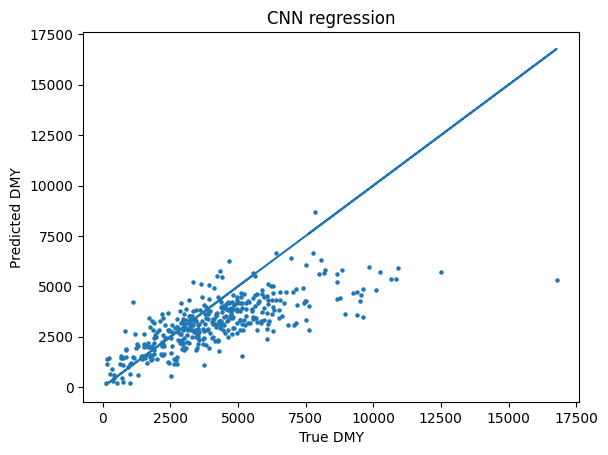

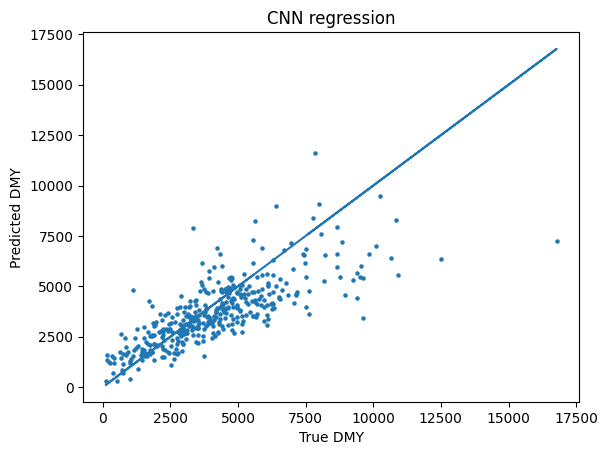

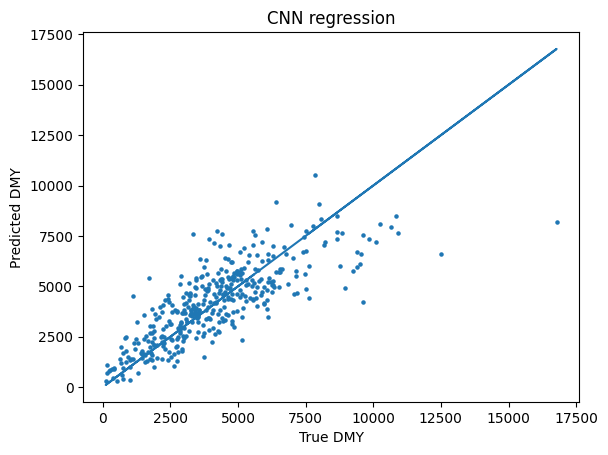

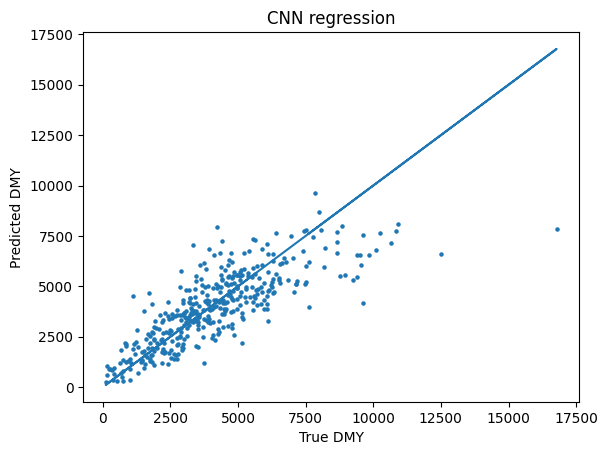

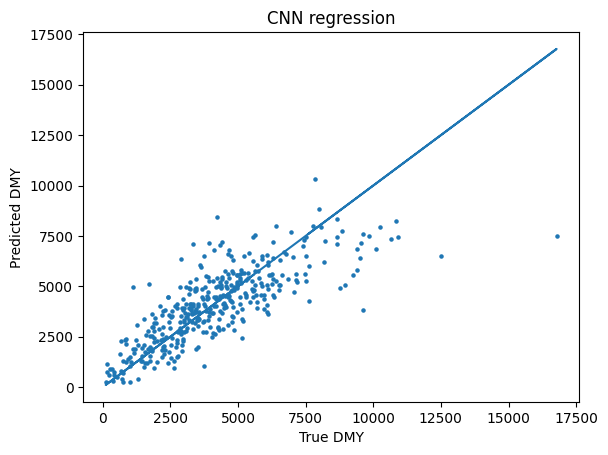

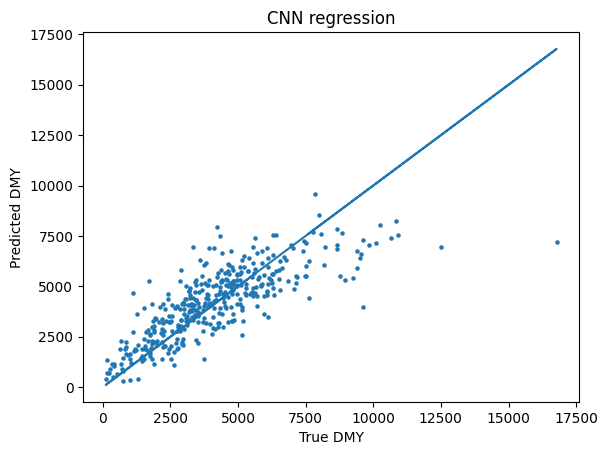

In [ ]:
model = make_model(ARCH, False) #True, False

# Define optimizer and loss function
criterion=nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=Learning_rate) #model.classifier.parameter

epochs = 25
val_Accuracy_appended = []
val_RMSE_appended = []
# change to cuda
if torch.cuda.is_available(): model.to('cuda')
Best_val_Accuracy = 0
Best_val_RMSE = 200000
Test_labels_best = 0
Test_predictions_best = 0


for e in range(epochs):
    #train loop
    model.train()
    train_all_losses = []
    train_all_accuracies = []

    for batch in train_loader:
        inputs, labels, id = batch
        if torch.cuda.is_available(): inputs, labels = inputs.to('cuda'), labels.to('cuda')
        optimizer.zero_grad()
        labels = labels.unsqueeze(1)

        # Forward pass
        outputs = model(inputs)
        labels = labels.float()
        #loss
        loss = criterion(outputs, labels)
        #accuracy
        labels = labels.cpu().numpy()
        outputs_accuracy = outputs.detach().cpu().numpy()
        accuracy = metrics.r2_score(labels, outputs_accuracy)
        MSE = metrics.mean_squared_error(labels, outputs_accuracy)
        #backward pass
        loss.backward()
        optimizer.step()

        train_all_losses.append(loss.item())
        train_all_accuracies.append(accuracy)

    #eval loop
    model.eval()
    Val_all_losses = []
    Val_predictions = []
    Val_labels = []
    with torch.no_grad():
        for val_batch in val_loader:
            val_inputs, val_labels, val_id = val_batch
            if torch.cuda.is_available(): val_inputs, val_labels = val_inputs.to('cuda'), val_labels.to('cuda')
            val_labels = val_labels.unsqueeze(1)
            val_outputs = model(val_inputs)
            val_labels = val_labels.float()
            #loss
            val_loss = criterion(val_outputs, val_labels)
            Val_all_losses.append(val_loss.item())
            #accuracy
            val_labels = val_labels.cpu().numpy()
            val_outputs_np = val_outputs.detach().cpu().numpy()
            Val_predictions.append(val_outputs_np)
            Val_labels.append(val_labels)

    #evaluation epoch
    Val_predictions= np.concatenate(Val_predictions)
    Val_labels=np.concatenate(Val_labels)
    val_Accuracy = metrics.r2_score(Val_labels, Val_predictions)
    val_RMSE = metrics.root_mean_squared_error(Val_labels, Val_predictions) #should have a smaller impact of outliers

    #Saving evaluations epoch
    val_Accuracy_appended.append(val_Accuracy)
    val_RMSE_appended.append(val_RMSE)

    print("Epoch: {}/{}... | ".format(e+1, epochs),
    "Train Loss {:.4f} | ".format(np.mean(train_all_losses)),
    "Train Accuracy {:.4f} |".format(np.mean(train_all_accuracies)),
    "Validation Loss {:.4f} | ".format(np.mean(Val_all_losses)),
    "Validation Accuracy {:.4f} |".format(val_Accuracy),
    "Validation RMSE {:.4f} |". format (val_RMSE))

    #test loop -> only added at the end, when all other experiments were already done
    model.eval()
    Test_predictions = []
    Test_labels = []
    with torch.no_grad():
        for test_batch in test_loader:
            test_inputs, test_labels, test_id = test_batch
            if torch.cuda.is_available(): test_inputs, test_labels = test_inputs.to('cuda'), test_labels.to('cuda')
            test_labels = test_labels.unsqueeze(1)
            test_outputs = model(test_inputs)
            test_labels = test_labels.float()
            #accuracy
            test_labels = test_labels.cpu().numpy()
            test_outputs_np = test_outputs.detach().cpu().numpy()
            Test_predictions.append(test_outputs_np)
            Test_labels.append(test_labels)

    #evaluation epoch
    Test_predictions= np.concatenate(Test_predictions)
    Test_labels=np.concatenate(Test_labels)
    test_Accuracy = metrics.r2_score(Test_labels, Test_predictions)
    test_RMSE = metrics.root_mean_squared_error(Test_labels, Test_predictions) #should have a smaller impact of outliers
    print("Test Accuracy {:.4f} ".format(test_Accuracy))
    print("Test RMSE {:.4f} ". format (test_RMSE))
    if val_Accuracy> Best_val_Accuracy and val_RMSE< Best_val_RMSE:
      Best_val_Accuracy = val_Accuracy
      Best_val_RMSE = val_RMSE
      Test_labels_best = Test_labels
      Test_predictions_best = Test_predictions
      plt.figure()
      plt.scatter(Test_labels_best, Test_predictions_best,s = 5)
      plt.plot(Test_labels_best,  Test_labels_best)
      plt.xlabel('True DMY')
      plt.ylabel('Predicted DMY')
      plt.title('CNN regression')
      plt.show
# best epoch chosen depending on the validation set!! not test set!